In [1]:
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation
plt.style.use('dark_background')

tau = 2 * np.pi

In [2]:
import sys
sys.path.append('../')

In [3]:
from modules.data_utils import parse_svg

points = parse_svg('../data/fourier.svg')
# Make it centered around the origin (optional).
points -= points.mean()
# Shift the center by a small amount.
shift = 0.1*np.ptp(points.real)
points += shift * np.exp(1j*tau*np.random.rand())

paths:   0%|          | 0/1 [00:00<?, ?it/s]

time:   0%|          | 0/1001 [00:00<?, ?it/s]

## Using numpy's Fast Fourier Transform

In [4]:
from fourier_core import get_alternating_sequence, inv_FFT

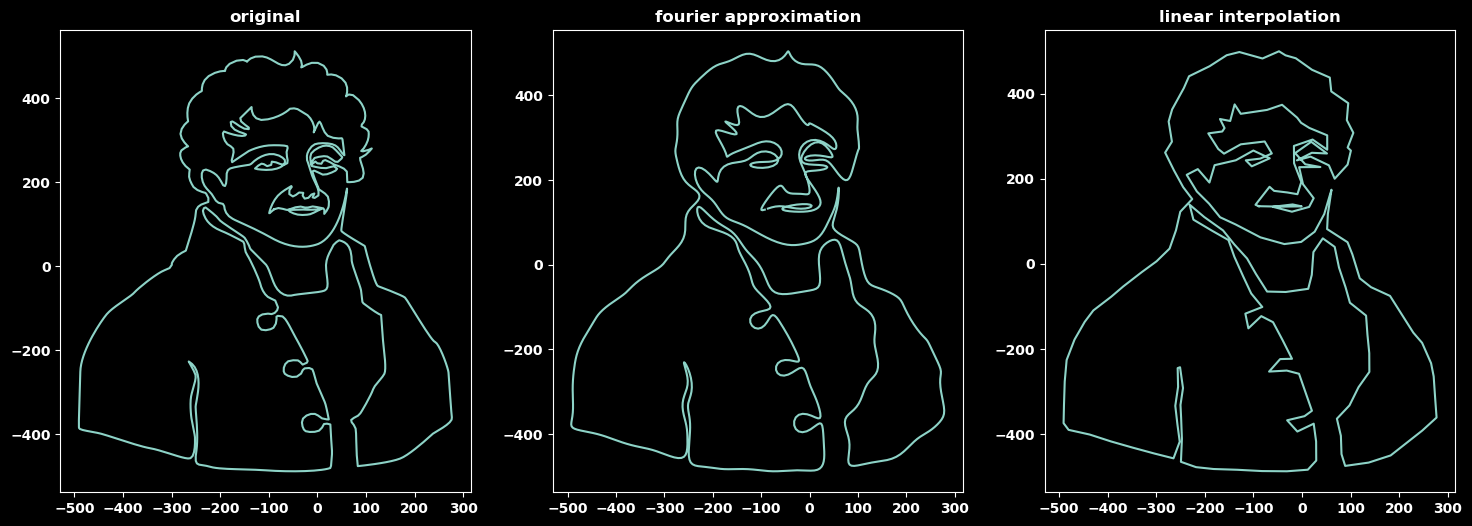

In [5]:
num_coeffs = None  # Would be taken as len(points) if None is passed.
coeffs = np.fft.fft(points, n=num_coeffs)
num_coeffs = len(coeffs)

n_pts_approx = 201
fig, axs = plt.subplots(1,3, figsize=(18,6))
axs[0].plot(points.real, points.imag)
axs[0].set_title('original')
points_appr = inv_FFT(coeffs, num_coeffs=n_pts_approx)
axs[1].plot(points_appr.real, points_appr.imag)
axs[1].set_title('fourier approximation')
points_appr = np.interp(np.linspace(0,len(points), n_pts_approx),
                        range(len(points)), points)
axs[2].plot(points_appr.real, points_appr.imag)
axs[2].set_title('linear interpolation')
plt.show()

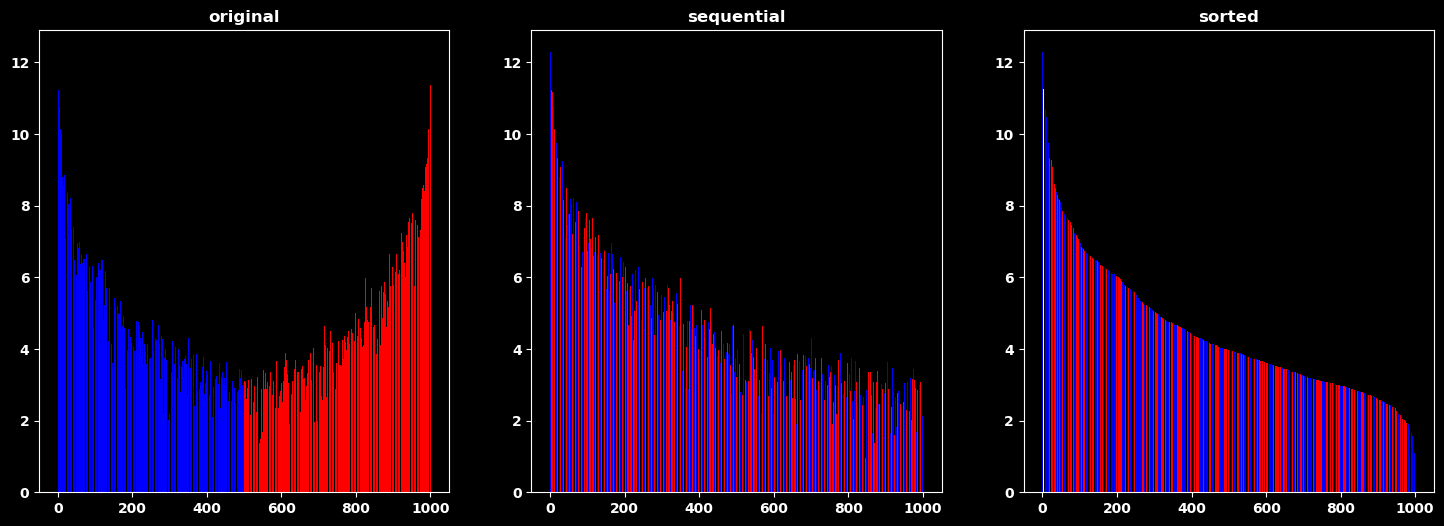

In [6]:
ignore_zeroth = False
freqs = coeffs
if ignore_zeroth:
  freqs = freqs[1:]

fig, axs = plt.subplots(1,3, figsize=(18,6))

colors = ['w'] + ['b']*(len(freqs)//2) + ['r']*(len(freqs)//2)
axs[0].bar(range(len(freqs)), np.log(1+abs(freqs)), color=colors)
axs[0].title.set_text('original')

sorted_indices = get_alternating_sequence(len(freqs))
freqs = freqs[sorted_indices]
colors = [colors[i] for i in sorted_indices]
axs[1].bar(range(len(freqs)), np.log(1+abs(freqs)), color=colors)
axs[1].title.set_text('sequential')

sorted_indices = np.argsort(abs(freqs))[::-1]
freqs = freqs[sorted_indices]
colors = [colors[i] for i in sorted_indices]
axs[2].bar(range(len(freqs)), np.log(1+abs(freqs)), color=colors)
axs[2].title.set_text('sorted')

plt.show()

if ignore_zeroth:
  sorted_indices += 1
  sorted_indices = np.insert(sorted_indices, 0, 0)

In [7]:
from modules.fourier_utils import compute_apprs_FFT

points_apprs = compute_apprs_FFT(coeffs, 201, None)

  0%|          | 0/201 [00:00<?, ?it/s]

### Animation

In [ ]:
from celluloid import Camera

#### Coeff Evolution

In [ ]:
fig, axs = plt.subplots()
camera = Camera(fig)
plt.axis('off')

for num_coeffs, points_appr in enumerate(tqdm(points_apprs[1:],
                                              desc='generating coeff evolution animation'), 1):
  plt.plot(points_appr.real, points_appr.imag, c='y')
  plt.text(0.4, 1.05, f'num coeffs: {num_coeffs}', transform=axs.transAxes)
  camera.snap()
plt.close(fig)  
  
anim = camera.animate()
FFwriter = animation.FFMpegWriter(fps=1)
anim.save(f"../animations/evolution.mp4", writer=FFwriter, dpi=300)
print('saved')

#### Time progress

In [ ]:
fig, axs = plt.subplots()
axs.set_aspect('equal')
camera = Camera(fig)
plt.axis('off')

# Sort the approximations (Optional).
# max_coeffs = points_apprs.shape[0]-1
# sequence = get_alternating_sequence(max_coeffs)
# new_coeffs = coeffs[sequence]
# new_sequence = sequence[np.argsort(abs(new_coeffs))[::-1]]
# points_apprs = compute_apprs_FFT(coeffs, max_coeffs, new_sequence)

for time_index in tqdm(range(len(points_apprs[-1])),
                        desc='generating time progress animation'):
  # Plot the lines.
  plt.plot(points_apprs.real[:, time_index],
           points_apprs[:, time_index].imag, c='w')
  # Plot the curve.
  plt.plot(points_apprs.real[-1, :time_index+1],
           points_apprs[-1, :time_index+1].imag, c='y')
  camera.snap()
plt.close(fig)  
  
anim = camera.animate()
FFwriter = animation.FFMpegWriter(fps=10)
anim.save(f"../animations/epicycles.mp4", writer=FFwriter, dpi=300)
print('saved')

### Widget

In [8]:
from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.widgets import Slider, CheckButtons, RadioButtons
from matplotlib.backend_bases import MouseButton

In [9]:
from modules.visualize import compute_orientations, compute_arrows, color_picker

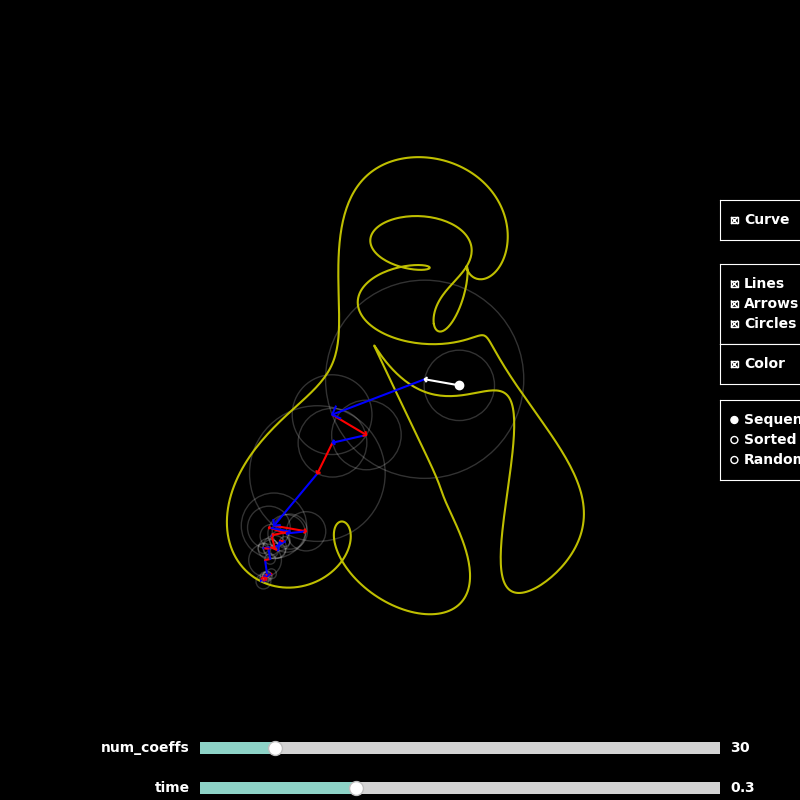

In [12]:
%matplotlib ipympl

fig, axs = plt.subplots(figsize=(8,8))
axs.set_aspect('equal')
axs.axis('off')
plt.subplots_adjust(bottom=0.15)
# plt.plot(points.real, points.imag, alpha=0.3)
rmin, rmax = points_apprs.real.min(), points_apprs.real.max()
imin, imax = points_apprs.imag.min(), points_apprs.imag.max()
x_pad, y_pad = 0.1*(rmax-rmin), 0.1*(imax-imin)
axs.set_xlim(rmin - x_pad, rmax + x_pad)
axs.set_ylim(imin - y_pad, imax + y_pad)

time = .3
num_coeffs = 30
max_coeffs, max_points = points_apprs.shape
max_coeffs -= 1

curve, = plt.plot([], c='y')
coll_lines = LineCollection([])
axs.add_collection(coll_lines)
coll_arrows = LineCollection([])
axs.add_collection(coll_arrows)
coll_circles = PatchCollection([], alpha=0.2, edgecolor='w', facecolor='None')
axs.add_collection(coll_circles)

origin = plt.scatter(0, 0, c='w', visible=False)
orientations = compute_orientations(points_apprs[:,0], points_apprs[:,1])
colors = list(map(color_picker, orientations))

# Define the function to update the plot based on interaction.
def update_plot_data():
  time_points = int(time*(max_points-1))
  vectors_appr = points_apprs[:num_coeffs+1, time_points]
  lines = np.column_stack((vectors_appr[:-1], vectors_appr[1:]))

  # Draw the curve.
  curve_appr = points_apprs[num_coeffs]
  if not curve_buttons.get_status()[0]:
    curve_appr = curve_appr[:time_points+1]
  curve.set_data(curve_appr.real, curve_appr.imag)

  # Draw the rotating lines.
  if check_buttons.get_status()[button_names.index('Lines')]:
    origin.set_visible(True)
    line_segments = np.dstack([lines.real, lines.imag])
    coll_lines.set_segments(line_segments)
    if color_buttons.get_status()[0]:
      coll_lines.set_colors(colors[:num_coeffs+1])
      coll_lines.set_colors(colors[:num_coeffs+1])
    else:
      coll_lines.set_colors('w')
  else:
    origin.set_visible(False)
    coll_lines.set_segments([])

  # Draw the arrows.
  if check_buttons.get_status()[button_names.index('Arrows')]:
    arrows = compute_arrows(lines)
    coll_arrows.set_segments(np.dstack([arrows.real, arrows.imag]))
    if color_buttons.get_status()[0]:
      coll_arrows.set_colors(colors[:num_coeffs+1])
    else:
      coll_arrows.set_colors('w')
  else:
    coll_arrows.set_segments([])   

  # Draw the circles.
  if check_buttons.get_status()[button_names.index('Circles')]:
    radii = abs(np.diff(vectors_appr))
    circles = [plt.Circle((center.real, center.imag), radius)
               for center, radius in zip(vectors_appr[:-1], radii, strict=True)]
    coll_circles.set_paths(circles)
    # Uncomment to have colored circles.
    # if color_buttons.get_status()[0]:
    #   coll_circles.set_edgecolors(colors[:num_coeffs])
    #   coll_circles.set_alpha(0.4)
    # else:
    #   coll_circles.set_edgecolors('w')
    #   coll_circles.set_alpha(0.2)
  else:
    coll_circles.set_paths([])


# Define the sliders.
ax_CoeffsSlider = plt.axes([0.25, 0.05, 0.65, 0.03])
Coeffs_slider = Slider(ax_CoeffsSlider, 'num_coeffs',
                       1, max_coeffs, valinit=num_coeffs, valstep=1)
def update_coeffs(num_coeffs_updated):
  global num_coeffs
  num_coeffs = num_coeffs_updated
  update_plot_data()
Coeffs_slider.on_changed(update_coeffs)

ax_TimeSlider = plt.axes([0.25, 0.0, 0.65, 0.03])
Time_slider = Slider(ax_TimeSlider, 'time',
                     0, 1, valinit=time, valstep=1e-4)
def update_time(time_updated):
  global time
  time = time_updated
  update_plot_data()
Time_slider.on_changed(update_time)


# Define the check buttons and radio buttons.
ax_CurveButtons = plt.axes([0.9, 0.7, 0.12, 0.05])
curve_buttons = CheckButtons(ax_CurveButtons, ['Curve'],
                             frame_props={'edgecolor': 'w'},
                             check_props={'facecolor': 'w'})
curve_buttons.on_clicked(lambda label: update_plot_data())
ax_CheckButtons = plt.axes([0.9, 0.57, 0.12, 0.1])
button_names = ['Lines', 'Arrows', 'Circles']
check_buttons = CheckButtons(ax_CheckButtons, button_names,
                             frame_props={'edgecolor': 'w'},
                             check_props={'facecolor': 'w'})

check_buttons.on_clicked(lambda label: update_plot_data())

ax_ColorButtons = plt.axes([0.9, 0.52, 0.12, 0.05])
color_buttons = CheckButtons(ax_ColorButtons, ['Color'],
                             frame_props={'edgecolor': 'w'},
                             check_props={'facecolor': 'w'})
color_buttons.on_clicked(lambda label: update_plot_data())
ax_RadioButtons = plt.axes([0.9, 0.4, 0.12, 0.1])
def on_click(label):
  global points_apprs, orientations, colors
  sequence = get_alternating_sequence(max_coeffs)
  new_coeffs = coeffs[sequence]
  if label == 'Sequential':
    new_sequence = sequence
  elif label == 'Sorted':
    new_sequence = sequence[np.argsort(abs(new_coeffs))[::-1]]
  elif label == 'Randomized':
    new_sequence = np.random.permutation(sequence)
  points_apprs = compute_apprs_FFT(coeffs, max_coeffs, new_sequence)
  orientations = compute_orientations(points_apprs[:,0], points_apprs[:,1])
  colors = list(map(color_picker, orientations))
  update_plot_data()
sort_buttons = RadioButtons(ax_RadioButtons, ['Sequential', 'Sorted', 'Randomized'],
                             radio_props={'edgecolor': 'w', 'facecolor': 'w'})
sort_buttons.on_clicked(on_click)

# Initialize buttons.
curve_buttons.set_active(0)
for i in range(len(check_buttons.labels)):
  check_buttons.set_active(i)
color_buttons.set_active(0)


# Add key press.
def on_press(event):
  if event.key == 'right' and num_coeffs < max_coeffs:
    Coeffs_slider.set_val(num_coeffs + 1)
  elif event.key == 'left' and num_coeffs > 1:
    Coeffs_slider.set_val(num_coeffs - 1)
fig.canvas.mpl_connect('key_press_event', on_press)

# Add scroll event.
def on_scroll(event):
  global time
  dt = 1e-2
  time -= dt * event.step
  time = np.clip(time, 0, 1)
  Time_slider.set_val(time)
fig.canvas.mpl_connect('scroll_event', on_scroll)

# Initial plot with the params defined at the top.
update_plot_data()
plt.show()

In [11]:
plt.close()